In [57]:
from kafka import KafkaConsumer
from tensorflow.keras.models import load_model, save_model
import numpy as np
from sklearn.metrics import accuracy_score
import io
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pickle
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

#cleaning the datastream
def prepare_stream(stream):
    data_str = stream.value.decode('utf-8').strip()
    data_list = data_str.split(',')
    data_list[0] = data_list[0].strip('"')
    data_list[-1] = data_list[-1].strip('"\\n')
    return data_list

#handling categoricalfeatures
def hash_categorical_value(value, num_buckets):
    return hash(value) % num_buckets


#preprocessing the input stream
def preprocess(df):

    df = df.dropna()

    #convert all string values to their equivalent int and float
    columns_to_convert_float = ['entropy', 'labels_average']
    for col in columns_to_convert_float:
        try:
            df[col] = df[col].astype(float)
        except ValueError as e:
            df = df[~df[col].str.contains('[^\d.-]')]
            df[col] = df[col].astype(float)
   

    columns_to_convert_int = ["FQDN_count","subdomain_length","upper","lower","numeric","special","labels","labels_max","len","subdomain","Target_Attack"]
    df[columns_to_convert_int] = df[columns_to_convert_int].astype(int)

    categorical_cols = ['longest_word', 'sld']

    
    for col in categorical_cols:
        num_buckets = df[col].nunique()
        df[col] = df[col].apply(lambda x: hash_categorical_value(x, num_buckets))

    df[['Minutes', 'Seconds']] = df['timestamp'].str.split(':', expand=True)
    df['Minutes'] = df['Minutes'].astype(int)
    df['Seconds'] = df['Seconds'].astype(float)
    df['Total_Seconds'] = df['Minutes'] * 60 + df['Seconds']

    df = df.drop(columns=['timestamp'])

    #normalize data
    y = df["Target_Attack"]
    X = df.drop("Target_Attack", axis = 1)
    scaler = MinMaxScaler()
    column_names = X.columns.tolist()
    X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=column_names)
    X["Target_Attack"] = y
    
    return df


#define lists to store the results
dynamic_model_precision= []
dynamic_model_fscore = []
dynamic_model_recall = []

static_model_precision = []
static_model_fscore = []
static_model_recall = []

#load the dynamic and static model
with open('best_xgb_model_corr.pkl', 'rb') as f:
    static_model = pickle.load(f)
with open('best_xgb_model_corr.pkl', 'rb') as f:
    dynamic_model = pickle.load(f)



window_size = 1000

window_data = []  
headers = True
#columns to define the heaer of the data
columns = ["timestamp","FQDN_count","subdomain_length","upper","lower","numeric","entropy","special","labels","labels_max","labels_average","longest_word","sld","len","subdomain","Target_Attack"]

#selected features used in the training part
selected_features_corr = ['FQDN_count', 'subdomain_length', 'lower', 'numeric', 'entropy',
       'special', 'labels', 'labels_max', 'labels_average', 'longest_word',
       'sld', 'subdomain']



i = 1
for m in consumer:
    if headers:
        headers = False
    else:
        window_data.append(prepare_stream(m))
        

    if len(window_data) == window_size:
        print("Window " + str(i) + ":")
        i += 1

        df = pd.DataFrame(window_data, columns=columns)
        processed_df = preprocess(df)
    
        true_labels = processed_df["Target_Attack"]
        X_stream = processed_df.drop(columns=["Target_Attack"])

        #predict the stream using the static model
        static_predictions = static_model.predict(X_stream[selected_features_corr])
        static_precision = precision_score(true_labels, static_predictions)
        static_model_precision.append(static_precision)
        static_recall = recall_score(true_labels, static_predictions)
        static_model_recall.append(static_recall)
        static_f1 = f1_score(true_labels, static_predictions)
        static_model_fscore.append(static_f1)

        #predict the stream using the dynamic model
        dynamic_predictions = dynamic_model.predict(X_stream[selected_features_corr])
        dynamic_precision = precision_score(true_labels, dynamic_predictions)
        dynamic_model_precision.append(dynamic_precision)
        dynamic_recall = recall_score(true_labels, dynamic_predictions)
        dynamic_model_recall.append(dynamic_recall)
        dynamic_f1 = f1_score(true_labels, dynamic_predictions)
        dynamic_model_fscore.append(dynamic_f1)

        #retrain the dynamic model with the new data
        dynamic_model.fit(X_stream[selected_features_corr], true_labels)


        #print the results of the window
        print(f'Dynamic Model F1 Score: {dynamic_f1}')
        print(f"Dynamic Model Precision: {dynamic_precision}")
        print(f"Dynamic Model Recall: {dynamic_recall}")
        print(f'Static Model F1 Score: {static_f1}')
        print(f"Static Model Precision: {static_precision}")
        print(f"Static Model Recall: {static_recall}")
        print("----------------------------------------")
        

        window_data = []

print(f'Dynamic Model Mean F1 Score: {sum(dynamic_model_fscore) / len(dynamic_model_fscore)}')
print(f'Dynamic Model Mean Precision: {sum(dynamic_model_precision) / len(dynamic_model_precision)}')

print(f'Dynamic Model Mean F1 Score: {sum(static_model_fscore) / len(static_model_fscore)}')
print(f'Dynamic Model Mean Precision: {sum(static_model_precision) / len(static_model_precision)}')


Window 1:
Dynamic Model F1 Score: 0.841075794621027
Dynamic Model Precision: 0.7371428571428571
Dynamic Model Recall: 0.9791271347248577
Static Model F1 Score: 0.841075794621027
Static Model Precision: 0.7371428571428571
Static Model Recall: 0.9791271347248577
----------------------------------------
Window 2:
Dynamic Model F1 Score: 0.8517049960348928
Dynamic Model Precision: 0.7468706536856745
Dynamic Model Recall: 0.9907749077490775
Static Model F1 Score: 0.842948717948718
Static Model Precision: 0.7450424929178471
Static Model Recall: 0.9704797047970479
----------------------------------------
Window 3:
Dynamic Model F1 Score: 0.8187702265372169
Dynamic Model Precision: 0.7301587301587301
Dynamic Model Recall: 0.9318600368324125
Static Model F1 Score: 0.8293838862559241
Static Model Precision: 0.7261410788381742
Static Model Recall: 0.9668508287292817
----------------------------------------
Window 4:
Dynamic Model F1 Score: 0.855151045701007
Dynamic Model Precision: 0.759284731774

KeyboardInterrupt: 

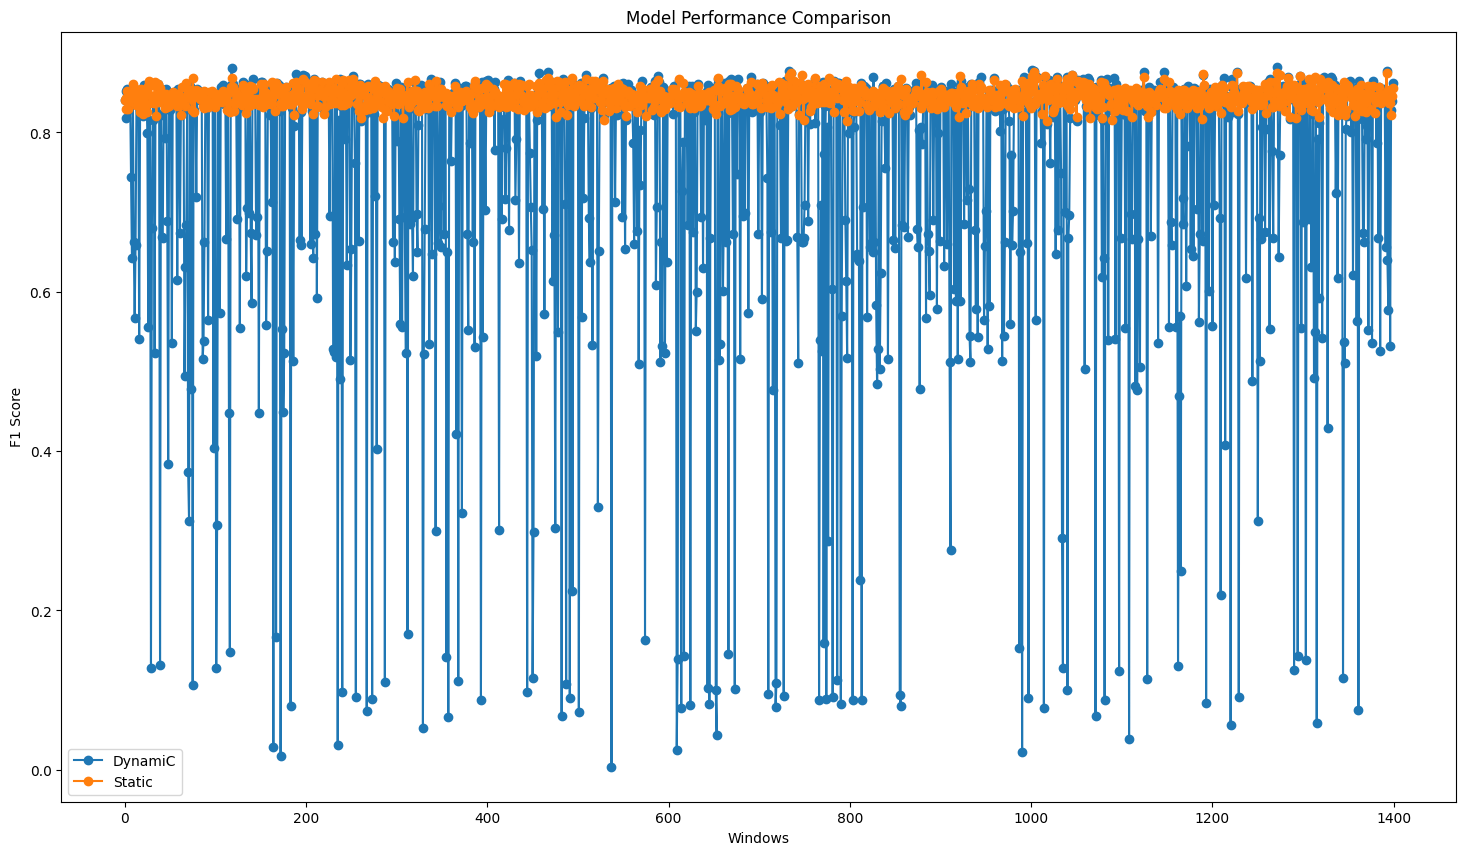

In [58]:
plt.figure(figsize=(18, 10))

plt.plot(dynamic_model_fscore, label='DynamiC', marker='o')
plt.plot(static_model_fscore, label='Static', marker='o')

plt.title('Model Performance Comparison')
plt.xlabel('Windows')
plt.ylabel('F1 Score')
plt.legend()
plt.savefig('Model static-dynamic Performance Comparison - fscore.png')
plt.show()

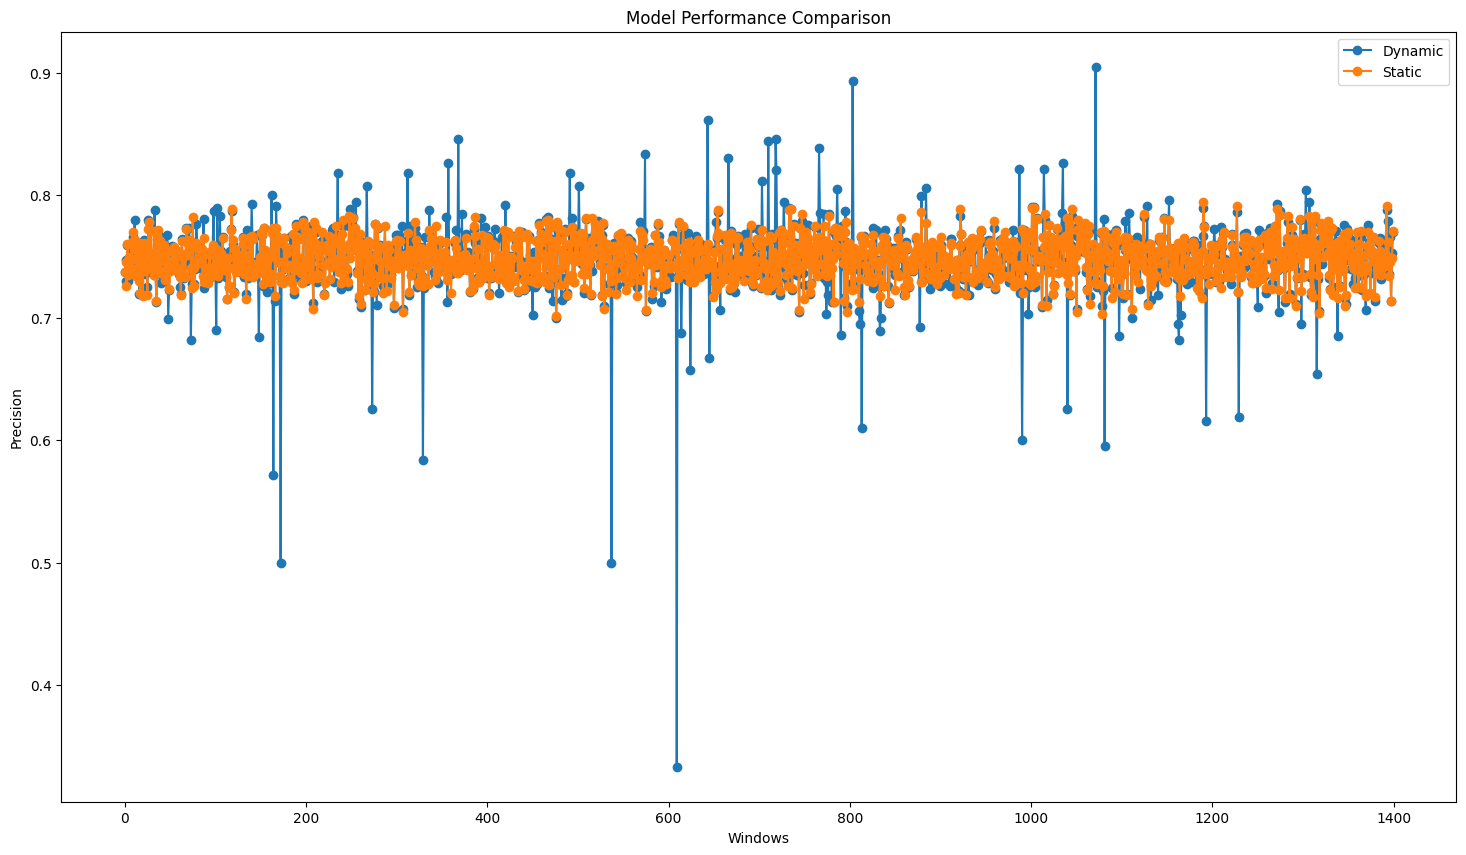

In [59]:
plt.figure(figsize=(18, 10))

plt.plot(dynamic_model_precision, label='Dynamic', marker='o')
plt.plot(static_model_precision, label='Static', marker='o')

plt.title('Model Performance Comparison')
plt.xlabel('Windows')
plt.ylabel('Precision')
plt.legend()
plt.savefig('Model static-dynamicPerformance Comparison - Precision.png')
plt.show()

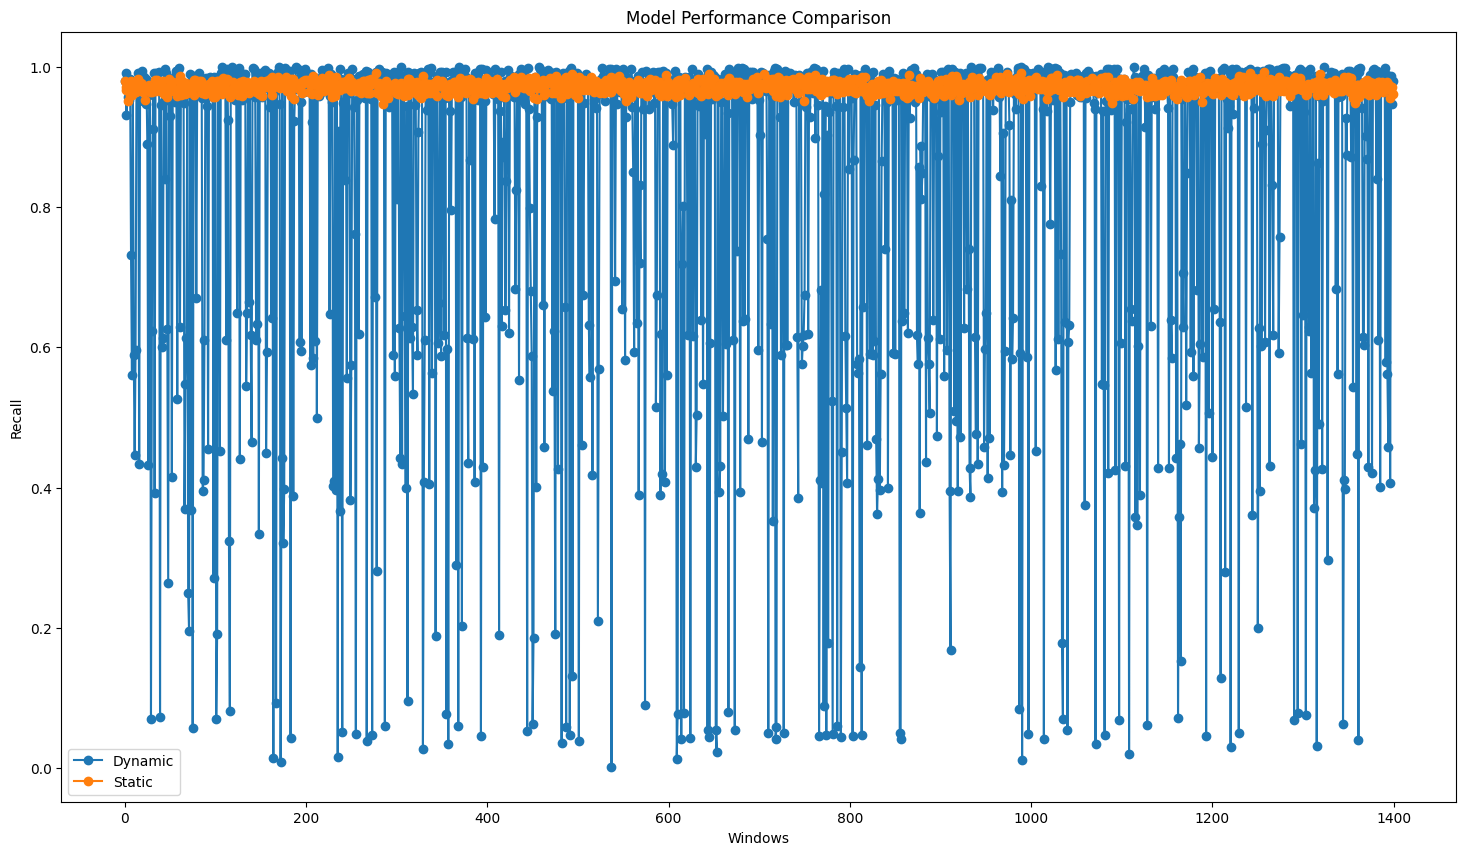

In [60]:
plt.figure(figsize=(18, 10))

plt.plot(dynamic_model_recall, label='Dynamic', marker='o')
plt.plot(static_model_recall, label='Static', marker='o')

plt.title('Model Performance Comparison')
plt.xlabel('Windows')
plt.ylabel('Recall')
plt.legend()
plt.savefig('Model static-dynamicPerformance Comparison - Recall.png')
plt.show()